# Цель работы

Дан многомерный размеченный набор данных. Необходимо выполнить предиктивный анализ данных на основе регрессионных моделей в соответствии со следующей последовательностью этапов.

# Ход работы

1. Загрузить необходимые пакеты и библиотеки.
2. Загрузить данные из указанного источника.
3. Выполнить разведочный анализ данных в соответствии с этапами описанными в файле Этапы проекта машинного обучения в примерах 1/2.pdf:

    a. Ознакомление с данными с помощью методов описательной статистики;
    
    b. Выполнить визуализацию данных одномерную для понимания распределения данных и многомерную для выяснения зависимостей между признаками;
    
    c. При необходимости выполнить очистку данных одним из методов.
    
    d. Проанализировать корреляционную зависимость между признаками;
    
    e. Поэкспериментировать с комбинациями атрибутов. При необходимости добавить новые атрибуты в набор данных.
    
    f. Выполнить отбор существенных признаков. Сформировать набор данных из существенных признаков.
    
    g. При необходимости преобразовать текстовые или категориальные признаки одним из методов.
    
    h. Выполнить преобразование данных для обоих наборов (исходного и сформированного) одним из методов по варианту.
    
4. В имеющихся двух наборах данных (исходном и их существенных признаков) выделить обучающую и тестовую выборки данных.
5. Сравнить линейную (по варианту) и полиномиальную регрессионные модели на обучающих выборках для обоих наборов данных. Для оценки качества моделей использовать метрики: корень из среднеквадратичной ошибки, R2.
6. Для лучшей модели на лучшем наборе данных выполнить Grid поиск лучшего гиперпараметра регрессионной модели на обучающей выборке. Построить графики результатов поиска. Определить значение лучшего гиперпараметра.
7. Для лучшей модели на лучшем наборе данных выполнить Grid поиск лучшего гиперпараметра регрессионной модели на тестовом выборке. Построить графики результатов поиска. Скорректировать значение лучшего гиперпараметра модели.
8. Сделать выводы по проведенному анализу.

# Исходные данные

Вариант 2.

Набор данных цен на недвижимость. Построить регрессионную модель для целевого признака «Y house price of unit area» (цена объекта недвижимости) от
остальных входных признаков.

- Пункт 3.h – Стандартизация
- Пункт 4 – эластичная сеть (регуляризованная линейная регрессия)

# Выполнение работы

## Загрузка используемых пакетов библиотек

In [1]:
import tarfile
import urllib.request
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from pickle import dump
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

%matplotlib inline
pd.options.mode.chained_assignment = None

## Загрузка исходных данных

In [2]:
HOUSING_URL = 'https://github.com/Demetrey/DMaP/blob/master/LR1/datasets/LR1_datasets.tar.gz?raw=true'
HOUSING_PATH = os.path.join('datasets', 'housing')

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'LR1_datasets.tar.gz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()
HOUSING_FILENAME = os.path.join(HOUSING_PATH, 'V2.csv')

In [5]:
def load_housing_data(path=HOUSING_FILENAME):
    df = pd.read_csv(path)
    # Первые 2 столбца содержат нумерацию 
    df.drop(['Unnamed: 0', 'No'], axis=1, inplace=True)  # inplace - изменение текущего df
    return df

In [6]:
housing = load_housing_data()

## Разведочный анализ данных

### Просмотр первых данных

In [7]:
housing.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,NaN,561.98450,5,24.98746,121.54391,47.3
3,2013.500,NaN,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Описание столбцов:
- X1 transaction date - дата транзакции;
- X2 house age - возраст дома;
- X3 distance to the nearest MRT station - расстояние до ближайшей станции метро;
- X4 number of convenience stores - количество магазинов шаговой доступности;
- X5 latitude - широта;
- X6 longitude - долгота;
- Y house price of unit area - стоимость за единицу площади.

### Определение размерности и типов данных

### Получение более подробной информации

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            205 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


В столбце X2 содержится 205 не пустых значений из 414.

### (a) Вывод описательной статистики

In [9]:
housing.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,205.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,18.206829,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.747338,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.000000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.200000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,30.300000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


### (b) Визуализация данных

#### Гистограммы

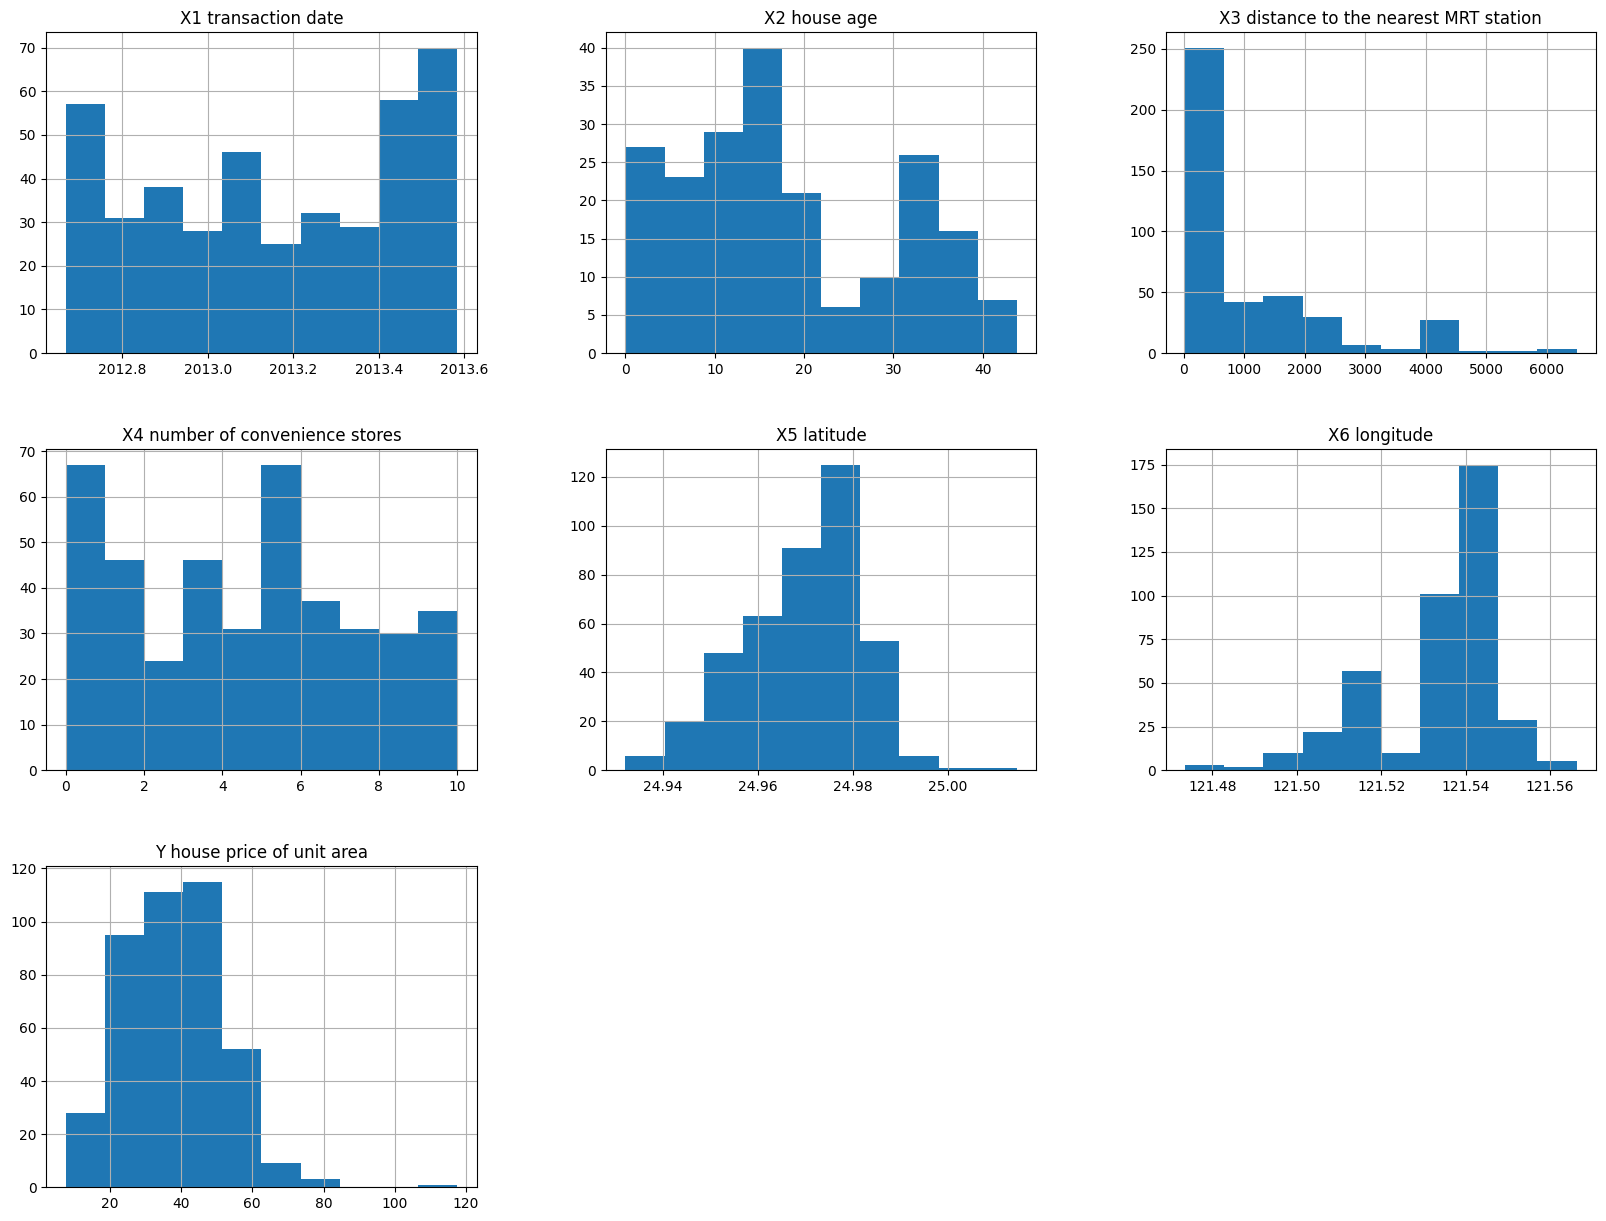

In [10]:
trash = housing.hist(bins=10, figsize=(20, 15))

#### Графики плотности распределения

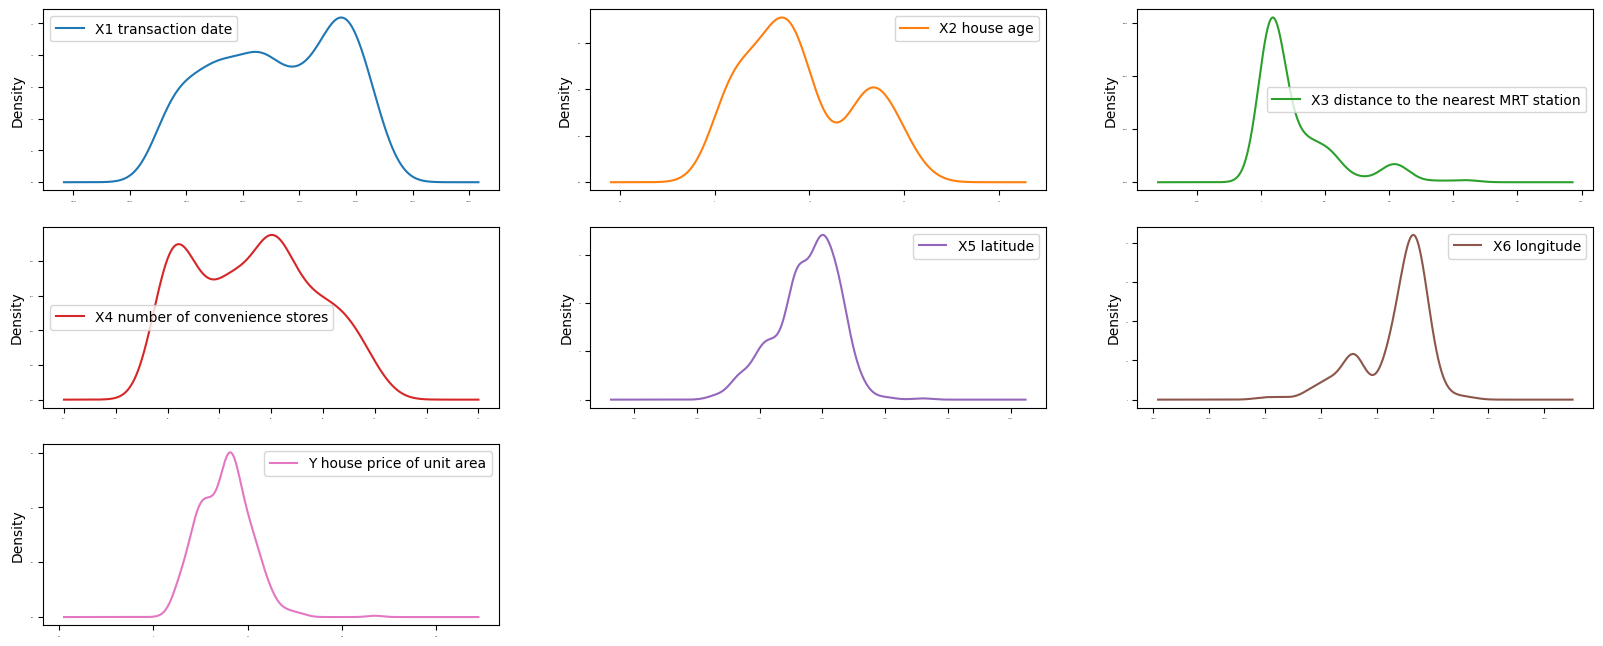

In [11]:
trash = housing.plot(kind='density', subplots=True, layout=(3, 3), sharex=False, legend=True, fontsize=1, figsize=(20,8))

#### График корреляционной матрицы

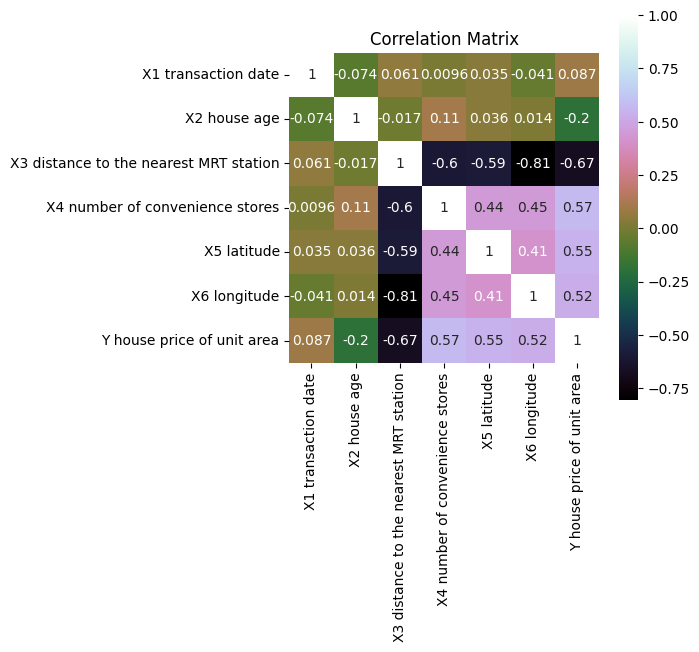

In [12]:
correlation = housing.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
trash = sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

#### Диаграмма рассеивания

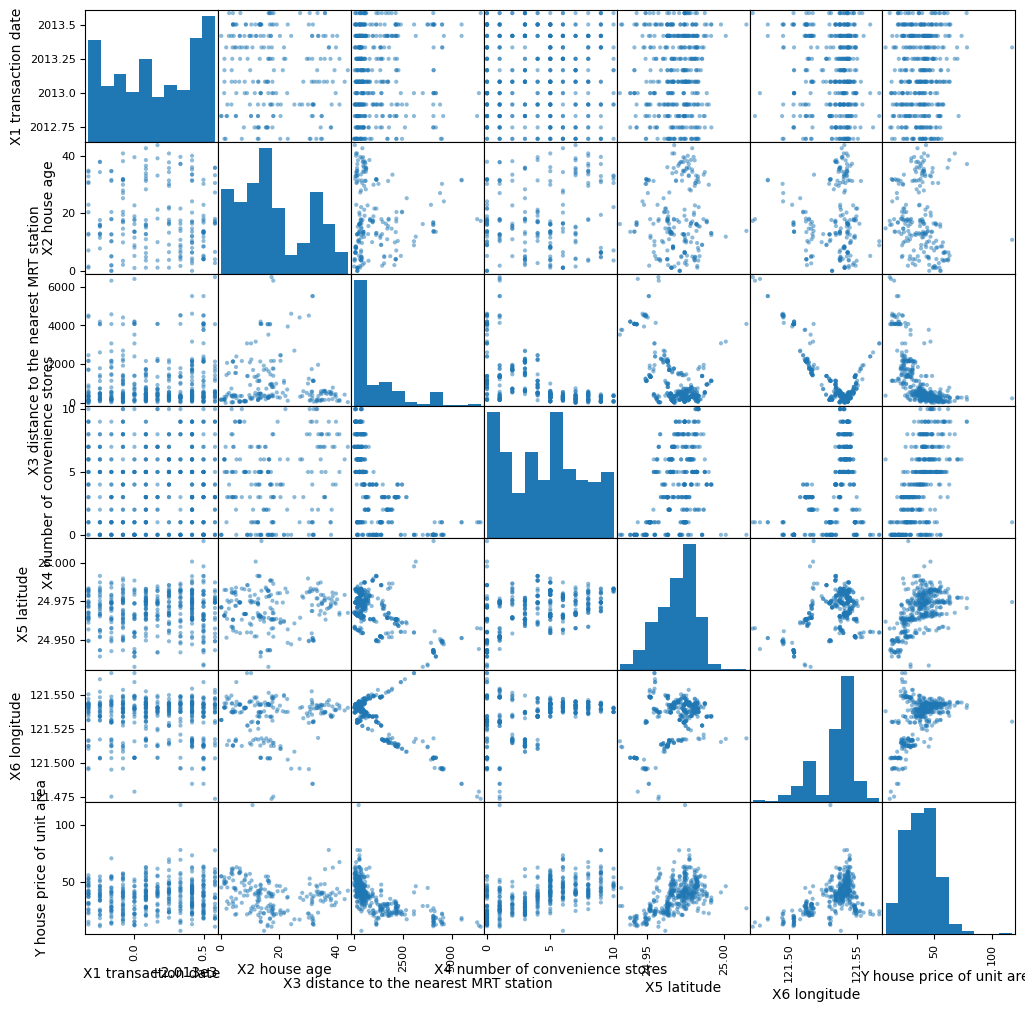

In [13]:
trash = scatter_matrix(housing, figsize=(12, 12))

#### (с) Выполним очистку данных

Проведем очистку данных несколькими методами:
- удалим соответствующие записи;
- установим недостающие значения на медиану;
- установим недостающие значения на среднее;
- установим недостающие значения на 0.

In [14]:
lst_housing_X2_Y = [housing.iloc[:, [1, 6]] for _ in range(4)]
lst_housing_X2_Y[0].dropna(inplace=True)  # Удаление строк
name_x2 = housing.columns[1]
# заполнение медианой
median = lst_housing_X2_Y[1][name_x2].median()
lst_housing_X2_Y[1][name_x2].fillna(median, inplace=True)
# заполнение средним
avg = lst_housing_X2_Y[2][name_x2].mean()
lst_housing_X2_Y[2][name_x2].fillna(avg, inplace=True)
# заполнение нулем
lst_housing_X2_Y[3][name_x2].fillna(0, inplace=True)

Выведем коээфициенты корреляции для каждого случая:

In [15]:
names = ['del_rows', 'median', 'mean', 'zeros']
for name, tab in zip(names, lst_housing_X2_Y):
    x2_y_corr = tab.corr()
    print(f'corr(X2_{name}, Y) = {x2_y_corr.iloc[0, 1]:.3f}')

corr(X2_del_rows, Y) = -0.195
corr(X2_median, Y) = -0.144
corr(X2_mean, Y) = -0.144
corr(X2_zeros, Y) = -0.098


По результатам построения корреляционных матриц, можно сделать вывод, что замена значений и удаление соответствующих записей не дает улучшений значения коэффициента корреляции по сравнению с исходными значениями корреляционной матрицы. По сравнению с другими параметрами (X3-X6), X2 имеет малый коэффициент корреляции, им можно пренеберечь.

In [16]:
housing.drop([housing.columns[1]], axis=1, inplace=True)
housing

,X1 transaction date,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,84.87882,10,24.98298,121.54024,37.9
1,2012.917,306.59470,9,24.98034,121.53951,42.2
2,2013.583,561.98450,5,24.98746,121.54391,47.3
3,2013.500,561.98450,5,24.98746,121.54391,54.8
4,2012.833,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...
409,2013.000,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,90.45606,9,24.97433,121.54310,50.0
411,2013.250,390.96960,7,24.97923,121.53986,40.6
412,2013.000,104.81010,5,24.96674,121.54067,52.5


#### (d) Анализ корелляционной зависимости между признаками

<Axes: title={'center': 'Correlation Matrix'}>

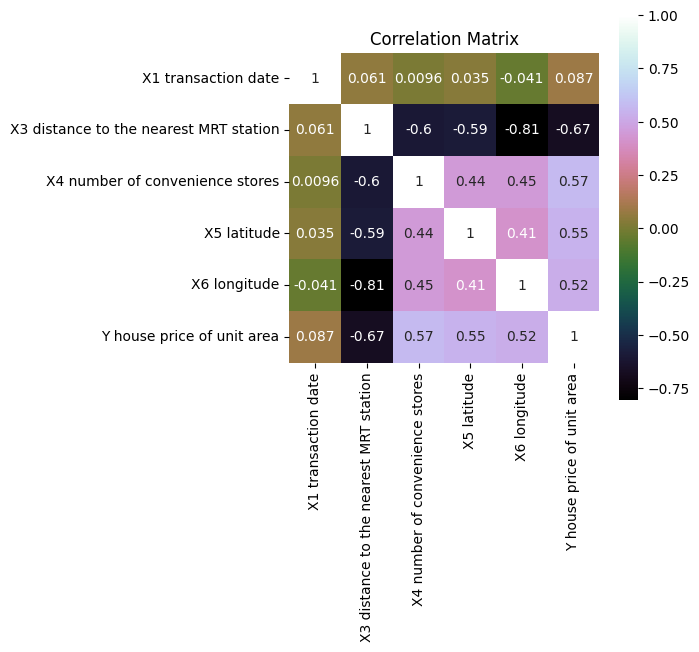

In [17]:
correlation = housing.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

#### Вывод сортированных значений коэффициентов корреляции по Y

In [18]:
correlation[housing.columns[-1]].sort_values(ascending=False, key=lambda x: abs(x))

Y house price of unit area                1.000000
X3 distance to the nearest MRT station   -0.673613
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
Name: Y house price of unit area, dtype: float64

Согласно интерпретации коэффициента корреляции по шкале Чеддока:
* X1 близко к 0, что означает отсутствие линейной корреляции;
* X3 - средняя отрицательная корреляция;
* X4-X6 - средняя положительная корреляция.

#### Построение диаграмм рассеиваний для значений X3-X6

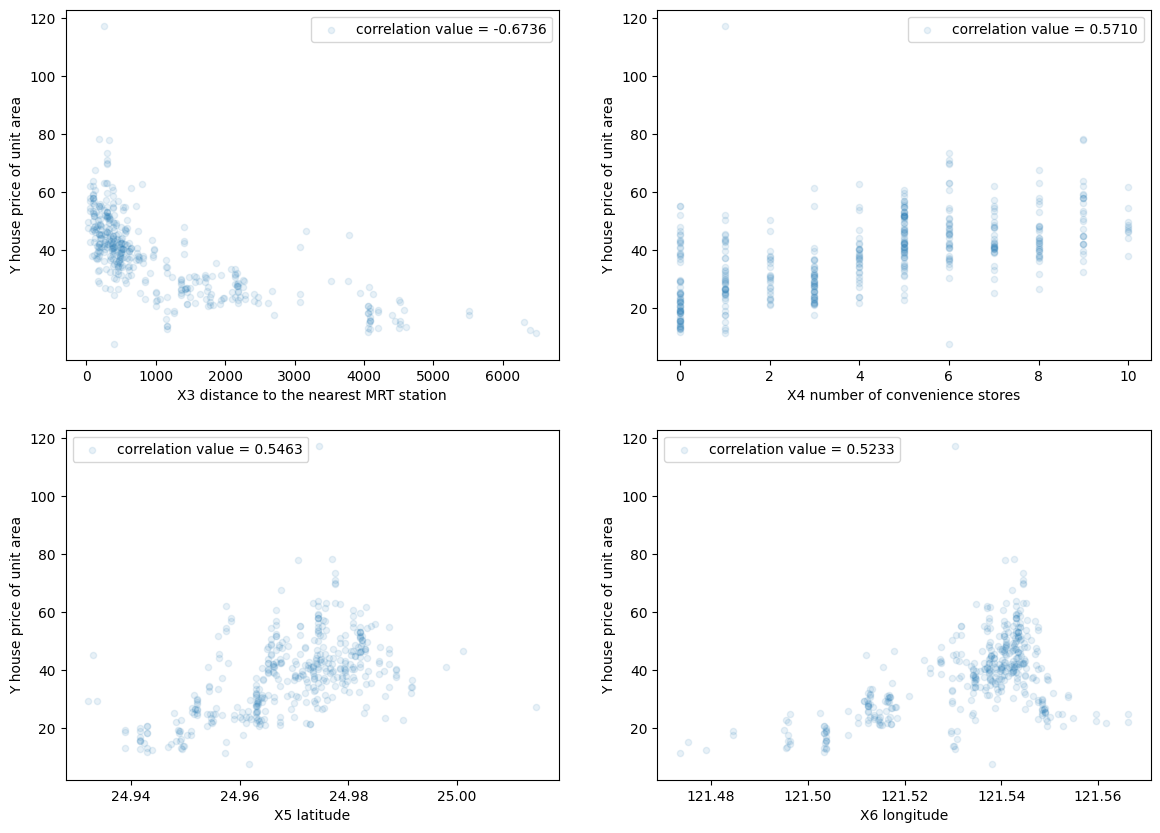

In [19]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
name_y = housing.columns[-1]
for name_x, ax in zip(housing.columns[1:-1], axes.ravel()):
    housing.plot(ax=ax, kind='scatter', x = name_x, y = name_y, label=f'correlation value = {correlation[name_y][name_x]:.4f}', alpha=0.1)

#### (e) Комбинации атрибутов

Так как по логике и здравому смыслу объединить атрибуты мы не можем, выполним полный перебор
**???????????????**

In [22]:
corr_y = pd.DataFrame(columns=['i', 'j', 'i/j', 'j/i'])
y = housing[housing.columns[-1]]
for name in housing.columns[:5]:
    print(name)
for i in range(4):
    for j in range(i + 1, 5):
        name_xi = housing.columns[i]
        name_xj = housing.columns[j]
        r1 = housing[name_xi] / housing[name_xj]
        r2 = housing[name_xj] / housing[name_xi]
        df = pd.DataFrame(data={'r1': r1, 'r2': r2, 'y': y})
        corr = df.corr()
        corr_y.loc[len(corr_y.index)] = [name_xi[:2], name_xj[:2], corr['y']['r1'], corr['y']['r2']]
# Сортировка по максимальному по модулю для xi и xj
corr_y.sort_values(by='i', ascending=False, key=lambda x: abs(corr_y.iloc[:, 2:]).max(axis=1))

X1 transaction date
X3 distance to the nearest MRT station
X4 number of convenience stores
X5 latitude
X6 longitude


,i,j,i/j,j/i
0,X1,X3,0.455805,-0.673631
5,X3,X5,-0.673608,0.455841
6,X3,X6,-0.673574,0.455754
1,X1,X4,-0.399810,0.570986
8,X4,X6,0.570980,-0.399756
7,X4,X5,0.570954,-0.399644
2,X1,X5,-0.506887,0.506759
4,X3,X4,-0.503675,0.431922
9,X5,X6,0.447113,-0.447274
3,X1,X6,-0.279823,0.279757


#### (f) Отбор существенных (информативных) признаков

In [ ]:
housing_X = housing.iloc[:, 0:5]
housing_Y = housing['Y house price of unit area']
bestfeatures = SelectKBest(k=5)
fit = bestfeatures.fit(housing_X, housing_Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(housing_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores

Исходя из полученных значений, наиболее информативными признаками являются X3-X6. Уберем данный столбец.

#### (g) Стандартизация

In [ ]:
housing_x = housing.iloc[:, :5]  # отбираем иксы
scaler = StandardScaler().fit(housing_x)
starter_housing = pd.DataFrame(scaler.fit_transform(housing_x))
shousing_x = starter_housing.drop(0, axis=1)
print(shousing_x)
print(starter_housing)

Сохраним модель

In [ ]:
save_data = pd.concat([shousing_x, housing[housing.columns[-1]]], axis=1)
save_name = 'funale_model.sav'
save_path = os.path.join(HOUSING_PATH, save_name)
dump(shousing_x, open(save_path, 'wb'))

### Выделим обучающую и тестовую выборки

Размер тестовой выборки: 20%

In [ ]:
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(shousing_x, housing_Y, test_size=validation_size, random_state=seed)
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(starter_housing, housing_Y, test_size=validation_size, random_state=seed)

In [ ]:
a = pd.DataFrame({'Elastic Net (first)': [None, None], 'Elastic Net (second)': [None, None], 'Polynomial (first)': [None, None], 'Polynomial (second)': [None, None]})
a.set_index(np.array(['RMSE', 'R2_score']), inplace=True)
a

### Применение линейной регрессии (эластичная сеть) для существенных признаков

In [ ]:
def f(x, y):
    model = ElasticNet(alpha=0.5)
    model.fit(x, y)
    Y_pred = model.predict(x)
    rmse_elnet = np.sqrt(mean_squared_error(y, Y_pred))
    r2_elnet = r2_score(y, Y_pred)
    print("RMSE for Elastic Net:", rmse_elnet)
    print("R2_score for Elastic Net:", r2_elnet)
    return Y_pred

In [ ]:
Y_pred = f(X_train, Y_train)

i = 1
for x in X_train:
    plt.figure()
    sort_xy = pd.DataFrame({'X': X_train[x], 'Y': Y_pred})
    sort_xy = sort_xy.sort_values(by='X')
    plt.plot(X_train[x], Y_train, 'o')
    plt.plot(X_train[x], Y_pred, 'o')
    plt.plot(sort_xy.X, sort_xy.Y, "r-")

### Применение линейной регрессии (эластичная сеть) для исходных признаков

In [ ]:
Y_pred = f(X_train_s, Y_train_s)

for x in X_train_s:
    plt.figure()
    sort_xy = pd.DataFrame({'X': X_train_s[x], 'Y': Y_pred})
    sort_xy = sort_xy.sort_values(by='X')
    plt.plot(X_train_s[x], Y_train, 'o')
    plt.plot(X_train_s[x], Y_pred, 'o')
    plt.plot(sort_xy.X, sort_xy.Y, "r-")

### Применение полиномиальной регрессии (квадратичной) для существенных признаков

### Применение полиномиальной регрессии (квадратичной) для исходных признаков

### Тест с одним параметром (вне лабораторной работы)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(shousing_x.iloc[:, :1], housing_Y, test_size=validation_size, random_state=seed)

model = ElasticNet(alpha=0.5)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
rmse_elnet = np.sqrt(mean_squared_error(Y_train, Y_pred))
r2_elnet = r2_score(Y_train, Y_pred)
print("RMSE for Elastic Net:", rmse_elnet)
print("R2_score for Elastic Net:", r2_elnet)

plt.plot(X_train[1], Y_train, 'o')
plt.plot(X_train[1], Y_pred, 'o')
plt.plot(X_train[1], Y_pred, "r-")